# Lab 10 : Signal Analysis of Seismic Data

## Objectives

In this lab we will use FFTs to perform some basic signal processing using seismic data.

Pre Lab 10 prepared us for reading the data, applying a low pass filter, and calculating a PSD. We will not apply these ideas to some real world data.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [2]:
import numpy as np
import scipy.integrate as integ
import scipy.special as sf
import scipy.optimize as opt
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import scipy.linalg as la
rng = np.random.default_rng()
import urllib.request
import scipy.signal as signal

## Seismic Data

The prelab gave an introduction into reading and handling the acceleration data from a seismometer. We will be working with multiple data files in this lab, all of which are in the same format as the noise from the prelab:
1. The first line of the file can be skipped.
2. After the first line the first column is a date time stamp which can be ignored.
3. The second column contains the acceleration in units of $\mathrm{m/s^2}$ and is the data we will be analyzing.

When working with signals it is common to remove the DC level of the signal which means subtracting off the average. It is best to always subtract off the average of the signal prior to further analysis. **Subtract off the DC level from all signals.**

Typically when we think of seismic activity we think of large events: Earth quakes. The network of seismometers around the world constantly monitors the shaking of the Earth, most of the time they are measuring small deviations. A large enough group of people can also cause noticeable shaking. For over a decade the standard example of this has been the Beast Quake. This will be our first example.

We will be processing multiple signals and will want to store information about them. This will include the signal as a function of time, a filtered version of the signal, the FFT of the signal, the PSD of the signal, the times at which the signal is measured, and the frequencies in the signal. This is a lot of information to keep track of. I strongly recommend and encourage you to choose a consistent naming convention for the variables in which you store these quantities. It will make writing and reading the code much easier and may even help you avoid bugs.

Finally, since we will be making multiple plots of multiple signals we should choose a plotting style for each of the signals and use them consistently throughout the work. Thus we should choose a style (color, line style, *etc*.) for each signal and consistently use it in all plots we produce. This will make it much easier to know what we are looking at as we scroll through the notebook.

To begin our analysis copy the useful results from the prelab. In particular, your function for calculating the PSD.

In [3]:
def calculate_psd(signal, sampling_rate):
    """
    Params:
        signal
        sampling_rate 
    Returns:
        Power Signal Display
    """
    signal_fft = np.fft.rfft(signal)[1:]
    num = 2 * (np.abs(signal_fft)**2)
    N = len(signal)
    denom = N * sampling_rate
    psd = num/denom
    return psd

## Beast Quake

On January 08, 2011, the Seattle Seahawks were playing in the NFC Wild Card game against the New Orleans Saints. Leading by 3 points with under 4 minutes left they had the ball and were looking to seal a victory. A simple running play was called and history was made. The ball was handed off to Marshawn Lynch and he entered what has become known as "Beast Mode". What followed was an exhilarating 67 yard touchdown run involving breaking nine tackles, some in brutal fashion as he blasted through would be tacklers, to guarantee victory in the game. In the self-proclaimed home of the "Twelfth Man" (at least for the NFL) the crowd went wild, building as the run developed. So much so that the ground shook, literally. As it turns out, across the street from the stadium was a seismometer which recorded the reaction. The resulting event has been dubbed the "Beast Quake". The data from this seismometer is publicly available and we will analyze some of it. (See the end of the lab for more details about how this data was obtained and prepared for the lab.)

In the prelab you looked at noise in the seismometer from a brief period after the game had ended. Now we will analyze the signal collected during the run. Recall that the sampling rate for the seismometer at this time was 100 Hz. Read in the data and produce a nice plot of the signal. Also apply a low pass filter to the data, as in the prelab, and include the filtered signal in the plot along with the original unfiltered signal.

The data is available online from `https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/beast_quake.dat`.

In [ ]:
url = "https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/beast_quake.dat"
with urllib.request.urlopen(url) as fp:
    beastsignal = np.loadtxt(fp, usecols=1, skiprows=1, unpack=True)
sampling_rate_beast = 100

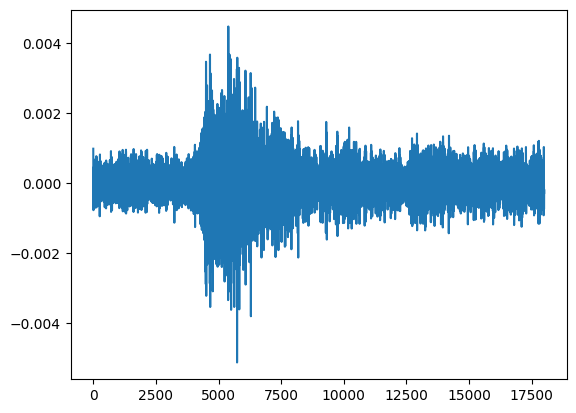

In [8]:
plt.plot(beastsignal)

In [ ]:
f_cut = 40

ix = np.where(frequencys >= f_cut)
ntilde = np.fft.rfft(beastsignal)
ntilde[ix] = 0
nprime = np.fft.irfft(ntilde)

times = np.linspace(0, duration/sampling_rate_beast,duration)

plt.plot(times, beastsignal, color = 'k', label = 'Original')
plt.plot(times, nprime, color = 'g', label = 'Lowpass')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (s)")
plt.title("Original versus Lowpass Signal")
plt.minorticks_on()

NameError: name 'frequencys' is not defined

Calculate the PSD for the filtered Beast Quake signal and produce a quick plot.

In [ ]:
calculate_psd(beastsignal)

## Seismic Swift

Despite many crowds gathering in many places both before and after, the Beast Quake has been the standard example of crowd induced seismic activity. It was an important and exciting event in the most popular US sport. What could possibly supersede it? What group of people could cause larger seismic activity? The obvious answer is "Swifties".

On July 22 and 23, 2023, Taylor Swift's Era Tour stopped in the same stadium in Seattle and for two nights the music and the crowd shook the ground. There is still a seismometer in the same location (though it has been upgraded, see the story a the end of the lab), so the seismic response was again measured. The data from these performances were analyzed, compared to the Beast Quake, and has lead to countless news stories comparing the two. The seismometer in question is part of the Pacific Northwest Seismic Network and they have their own [Blog Post](https://pnsn.org/blog/2023/08/15/beast-quake-taylor-s-version-from-the-vault) comparing the events with some useful information based on analysis by Dr. Jackie Caplan-Auerbach (a professional geologist) of Western Washington University. Articles appeared everywhere online including one in [The Seattle Times](https://www.seattletimes.com/seattle-news/science/taylor-swift-sang-shake-it-off-in-seattle-and-a-seismometer-felt-it/). These sources contain enough information to allow us to identify and process the signals ourselves. So we will.

Though the location of the seismometer did not change, the equipment had been upgraded. **The signals during the concert were collected with a sampling rate of 200 Hz.**

We will read in the signals from the two performances and produce a quick plot showing them. If you look at the professional figures in the online references you will see that they are typically made as long and thin plots (presumably from the time when the seismometer directly recorded the signal on long strips of paper). We can make our plot look like the professional ones by adjusting the `figsize`. Doing so makes it easier to compare to the published figures.

You will also find that the signals are shifted with respect to each other. From the news article it appears that there was a 26 minute delay at the start of the second performance. You can shift the second signal by 26 minutes if you like, we will determine the exact delay ourselves below. Regardless, you should find that the signals are very similar between the two days.

The data is now for the full concert. As noted at the end of the lab, storing data in a text file has advantages and disadvantages. One significant disadvantage is that the data files are huge: too large to store in git on GitHub! One advantage of storing numeric data in text files is that they can trivially be compressed. Further `np.loadtxt` can detect if a text file is compressed and decompress it as it reads the data! Unfortunately, this only works for locally stored files. It (for some reason) does not detect that a stream is compressed, so we will need to decompress the stream ourselves. Fortunately, a `with` statement can perform multiple operations and it does so sequentially allowing us to open a remote stream and decompress it, before running other code.

This is a long way of saying that we can use the following idiom to read in remote files that are compressed. Let `url` contain the url to a remote, gzip compressed file. Then
```
import io, gzip
with urllib.request.urlopen(url) as fpz, io.BytesIO(gzip.decompress(fpz.read())) as fp:
    X = np.loadtxt(fp)
```
will read in the file as plain text. (Of course you will want to change the call to `np.loadtxt` to read in the file in the same way as you did for the noise data in the prelab and the Beast Quake data above.)

Use this idiom to read in each day of the concert data from the following files
- Day 1: https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/shake_quake1.dat.gz
- Day 2: https://raw.githubusercontent.com/cwru-phys-250/resources/main/data/shake_quake2.dat.gz

**This is set up as a separate cell since the files are quite large meaning this process is very slow.** You do not want read them in multiple times! Ideally you will read them in only once and then process the data. *Once read in, do not overwrite the arrays in the subsequent analysis.*

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Subtract off the DC level and apply the same low pass filter to them as you did for the Beast Quake and produce a quick plot (shifted or not shifted) to get an idea of what the performance signals look like. Comparing to the plots from the provided links you should see they look very similar. Note that the signal is finely sampled. It is not necessary to plot every reading. Plotting every 10 or even 100 reading would be more than sufficient.

We will use the low pass filtered signals in the rest of our analysis.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Shake It Off Quake

Comparing this signal to that of the Beast Quake we see that the maximum amplitude is larger, suggesting a larger seismic event due to the concert. We will explore this in more detail. We see in the signal that there is a time when the amplitude was the largest. How can we isolate this signal? Appropriately, according to the links above, the largest shaking occurred during the song "Shake It Off", hence we have the "Shake It Off Quake".

### Day 1

To identify the location of the signal we can use the fact (which I'm sure we all know) that this song has a characteristic 160 beats per minute (bpm). To explore this, first calculate the PSD for the signal from day 1 of the concert. Produce a quick plot of the PSD. Find and print the frequency at which the PSD is a maximum. (It makes sense to print it in units of bpm.) Include a vertical line at 160 bpm in your plot. If you look closely you will also see a small peak at the first harmonic, 320 bpm, but it does not stand out as much as I would have thought. You probably also want to narrow the range on the $x$-axis so we can focus on the frequencies of interest. (Remember, the point of all plots is to convey information, we want to ensure that the plots are meaningful.)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Even without knowing the distinctive frequency of "Shake It Off" the PSD shows that 160 bpm is an important frequency as it contains a large spike in the power. Regardless of how we decide to focus on this frequency we can use it to filter the signal by cutting out all but a narrow window of frequencies centered on this one. The basic procedure is as follows.
1. Calculate the FFT of the signal.
2. Remove all frequencies below and above a small window of frequencies around 160 bpm. Choose a narrow window for yourself. This is equivalent to applying a "top hat" filter in frequency space.
3. Calculate the inverse FFT.
The resulting signal will only contain the frequencies in the narrow window you chose.

Perform these steps on the day 1 concert signal. Again produce a quick plot of the result.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

It will come as no surprise to you that there are multiple times at which the signal occurs since, as you certainly know, Taylor Swift uses a 160 bpm signature in a few songs. However, we have been told that the largest amplitude signal comes from "Shake It Off". We can find the index in the signal array where this occurs and use this to pull out the signal for this particular song. This will need to be done at least partially by hand. Slice out "Shake It Off" from the day 1 low pass filtered signal and produce a quick plot of it. You can compare your result to the plots from the provided links. (This is what I did to believe that I had found the correct signal.) As you also undoubtedly know, this song is 3 minutes and 39 seconds in length. We will want to slice out a slightly longer time than this. Make sure you have sliced out the full song, including a little bit of time before and after the song.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Day 2: Optimal Matched Filter

To find "Shake It Off" on day 2 of the concert we could follow the same procedure as above and/or use the claim that there is a 26 minute shift to slice out the signal. Instead we will use a more general technique: we will construct an optimal matched filter. This is a general approach for finding a "needle" (the song) in a "haystack" (the full performance). The basic idea is that we know what the signal should look like, we have a template, so we can find this template in the full signal. This is commonly used to find short, weak signals in long, noisy time streams. For example, LIGO uses this to find gravitational wave signals based on a calculated template bank of gravitational wave signals from the merger of compact objects (typically black holes and/or neutron stars). In fact, we will follow the procedure presented in a [LIGO tutorial](https://gwosc.org/tutorial_optimal/). The general procedure in the tutorial is good, the details leave a lot to be desired. Also, the tutorial uses the full FFT, but the same idea applies when using a real FFT.

For our application, ideally we would know the song we are looking for and have a guess as to what that signal should look like. We could take "Shake It Off", find its FFT, ..., then get something to use as a matched filter. The main problems with this are firstly that I am not going to upload copyrighted material to github for your use and secondly that we are not looking for the song directly, instead we are looking for the imprint it and the crowd has left on the seismometer. (See the end of the lab for more discussion.)

What we will do instead is use the signal we just found from day 1 as the template. With this we can construct an optimal matched filter. This is not completely correct as our template will have noise in it. We could correct this, but the main point here is to perform a matched filter, not get exact results.

To construct an optimal matched filter we proceed as follows (these are the steps in the linked tutorial).
1. Calculate the FFT of the full signal (the "haystack"). In our case this is the low pass filtered signal from day 2 of the concert.
2. Calculate the zero padded FFT of our template signal, i.e., the signal we are looking for (the "needle"). In our case this is the "Shake It Off" signal from day 1 we found above. The zero padding is necessary since the FFT assumes the signal is periodic. We do not want the template to "wrap around". Thus, we want to zero pad the signal such that it is the same length as the full day 2 concert signal. Recall that the FFT routines from NumPy will automatically do this zero padding for you if you tell it to.
3. Correct for the noise in the signal. As we know, our signal has noise (we are ignoring the noise in the template). To get an estimate of the noise we will use signal from day 2 of the concert at a time prior to when the performance started. Start at a time a few minutes in from the beginning of the day 2 signal and slice out about 5 minutes of the signal. We will call this our noise. Calculate the PSD (and frequencies) for the noise signal.
4. We want to "divide out" the power in the noise. However, the frequencies at which the PSD are evaluated are not the same as those for our signal (and template). To evaluate the noise PSD at the same frequencies we can interpolate. Perform this interpolation to determine the noise power at each signal frequency. This can be done using a spline as we have done in the past or by using `np.interp` as in the tutorial.
5. Let $\tilde{S}(f)$ be the FFT of the signal, $\tilde{T}(f)$ be the FFT of the template, and $P(f)$ be the interpolated noise power from the previous step. The optimal filter is then defined as
   $$ \tilde{O}(f) \equiv \frac{2 \tilde{S}(f) \tilde{T}^*(f)}{P(f)}, $$
where the * mean complex conjugation. You will need to be careful with the zero frequency bin. If you are using a full FFT instead of a real FFT you will also need to handle the negative frequencies appropriately. (You really want to be using he real FFT routines.)
6. This optimal filter can be converted to a signal-to-noise ratio (SNR). To do so we normalize the signal by the square root of the area under the curve,
   $$ \sigma \equiv \sqrt{\sum_{f} |\tilde{O}(f)|^2 \Delta f}, $$
where we are summing over all frequencies (technically $f>0$).
With this the optimal signal, $O(t)$, is the inverse FFT of $\tilde{O}(f)$ and the SNR is
   $$ \mathrm{SNR} = \frac{|O(t)|}{\sigma}. $$

Finally, we want to calculate the SNR for day 2 of the concert using the template we found above. Actually, we might as well calculate the SNR for both days (using the same template and the same noise). It thus makes sense to define a function that calculates the SNR given the signal, template, noise, and sampling rate. Use this function to calculate the SNR for both days and produce a quick plot of the results. Do not shift the results, we will next use these results to find the delay between the start of the performances on the two days.

In [ ]:
def optimal_filter_SNR(signal, template, noise, sampling_rate=200):
# YOUR CODE HERE
raise NotImplementedError()

You will find the two SNR look similar, are shifted with respect to each other, and that the largest signal occurs when "Shake It Off" was performed. Based on this we can determine the exact time delay between when this song was performed on the two days. (This is not necessarily the same as the delay in the start of day 2 as the pacing of the performances could have been slightly different and this song was one of the later ones performed.) Find the peak in the SNR for the two days and use the difference in them to determine the exact delay between the two performances. Print the result in minutes and seconds. (You will find it is very close to 26 minutes.)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

We can now extract the "Shake It Off" signal from both days of the concert. This can be done in a number of ways. The simplest way to do this is to use the fact that we have already extracted the signal from day 1 and now we know the exact shift between the two performances. We can use these to extract the signal from day 2. Thus we can just shift the slicing from day 1 to day 2 and extract the signal.

Extract the "Shake It Off" signal from the two days and produce a nice plot of the two "Shake It Off" performances.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Signal Amplitude

It is clear from the initial plots of the Beast Quake and the Shake It Off Quake that the Shake It Off Quake had a larger amplitude. What does this mean? Was the crowd at the concert more energetic than the crowd at the NFL game? Or maybe the subwoofers at the concert pumped more energy into the ground. How can we know?

I have not seen this analyzed (though I did not look very hard). As a first step, we can calculate the amplitude of the Fourier modes to determine how the power is distributed in frequency space. The PSD we calculated above was normalized to keep the noise power independent of things like the signal length and sampling rate. An alternative version of a PSD can be defined that gives us the amplitude of the modes in frequency space as
$$ A(f) \equiv \frac{2 |\tilde{S}(f)|}{N}, $$
where $N$ is the total number of samples and $\tilde{S}(f)$ is the FFT of the filtered signal. (In this case it is just the sliced out Shake It Off signal, not the signal from the full day of the concert.) Again, this is one-sided PSD for $f>0$ with the factor of 2 accounting for the power in both the positive and negative frequency modes. Notice that this has the same units as the signal.

Using this definition of a PSD (or amplitude) calculate it for all three signals (the Beast Quake and the two "Shake It Off" signals) and produce a nice plot showing them all. You may want to play with using the alpha channel to make sure we can clearly see all the signals, particularly since the Beast Quake and "Shake It Off" signals will overlap. We of course are only interested in the frequencies where something interesting is happening. Finally, to see anything of interest we probably want a semilog plot and to adjust the limits, as needed. Again, make a plot that shows the information we want to show as clearly as possible.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

Based on the previous results, do you think the crowd caused a larger signal at the concert than at the NFL game or was the larger amplitude at the concert due to the music directly? Justify your answer. Can you think of a way to test it?

YOUR ANSWER HERE

## Creating the Lab: A short story

Your first question can be: why were the assignments so long this week? For that you can blame global warming, i.e., the fact that Winter 2024 did not exist. In an actual winter snow falls. When snow falls, particularly further north, in a snow belt, I ski into a cabin without electricity or running water. Though I have much time when there, I do not have the facilities to spend it sitting in front of a computer working on interesting problems. However, when there is no snow (even further north, in a snow belt, as one would expect during winter), I instead spend my time sitting in front of a computer working on interesting problems. Since the problems are interesting, there are many aspects to explore, as you have seen. If nothing else, these assignments are further evidence of the dangers of global warming.

This lab began when I came across one of the many articles on the Taylor Swift concert and its comparison to the Beast Quake. From a quick glance at the article it was obvious that we could do this analysis. But how to proceed? First was to find the data. Through some searching, access to the network of seismic data was found. Access to such data is a natural progression of the open source movement; open data is now expected, particularly for government funded research (in fact, it is a requirement of many grants). In this case the [Pacific Northwest Seismic Network](https://pnsn.org/) provides information about the location and operation of seismometers in its region. The
[NSF SAGE Facility](https://service.iris.edu/fdsnws/dataselect/docs/1/builder/) provides an interface for downloading raw data, assuming we know for what seismometer to request. As with any "real" data, it is stored in field specific formats. Understanding the instruments used to collect the data and being able to process this data is often challenging and requires expert knowledge. Fortunately Python has become the standard language used in most fields. For seismic data [ObsPy](https://docs.obspy.org/) appears to be a standard tool, used by the professionals, for acquiring and processing the data.

Through some searching I found that the seismometer used to measure the Beast Quake and the Shake It Off Quake was part of the UW network, station KDK. With this information I could download data for any time period (over which the station was running) from the interface given above. There are many specialized formats used for this. Since ObsPy can handle any of them, I chose the binary format `mseed`. In general a binary format has the disadvantage that you cannot just look at it, you need something to read it for you, but has the advantage that the files are typically much smaller and faster to process. Since I was going to use something to read it for me, a binary format was preferred. To process the data I installed ObsPy in a separate conda environment. This is best practice. I do not need nor want ObsPy installed in general. It has a "one off" usage for me. I can create an environment, do the processing I want, then delete the environment, without making a mess of the standard python environments I use.

ObsPy could be used to do the data acquisition and all the processing we need; it really is a tool used by the professionals. It even makes the plots seen in the links provided above (handing the time stamps for us). I chose to download the data separately, but that was unnecessary. The data comes as raw signals, not as accelerations. To convert the raw signal to an acceleration requires knowing something about the instrument. To make matters more challenging, the actual seismometer has multiple channels and these changed between the times of the two signals. For the Beast Quake the ENZ channel was used for the signal we processed, whereas for the Shake It Off Quake the HNE channel was used. As we have seen, these channels are quite different, they even have different sampling rates. Fortunately ObsPy can do the conversion of the raw signal for us, thus I did not (and do not) know how it is actually done. It can query the public data repository for the relevant instrument parameters and apply the appropriate calibration. Finally, it could then write out the data we require in a format we can read without the need to use a specialized package.

This is a small insight into how, given the tools and techniques we have learned, we can start to perform real analyzes with real data. Starting from knowing nothing about seismology we can acquire and analyze real seismic data involving Taylor Swift. Could you have even imagined reaching such heights at the beginning of the semester?

## Member Participation

See Lab00 for instructions on turning in labs. We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who participated in this lab. Again, see Lab00 for more details. It is expected that you have read and understood those details.